In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 2.3 MB 10.9 MB/s 
     |████████████████████████████████| 138 kB 52.8 MB/s 
     |████████████████████████████████| 379 kB 46.2 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 357 kB 48.1 MB/s 
     |████████████████████████████████| 92 kB 11.1 MB/s 


In [ ]:
!pip install brotlicffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 5.1 MB/s 


In [ ]:
#Training images
import py7zr
import brotlicffi as brotli
import tarfile
with py7zr.SevenZipFile(f"/content/drive/MyDrive/Hamoye Internship/StageD/Data/train-jpg.tar.7z",mode="r") as z:
  z.extractall("/content")
my_tar = tarfile.open("/content/train-jpg.tar")
my_tar.extractall("/content")
my_tar.close()

In [ ]:
#Import csv file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Hamoye Internship/StageD/Data/train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


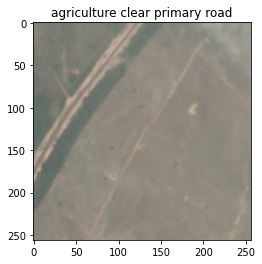

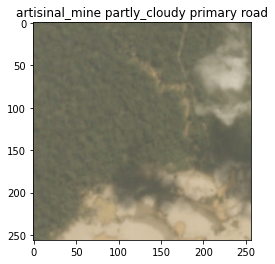

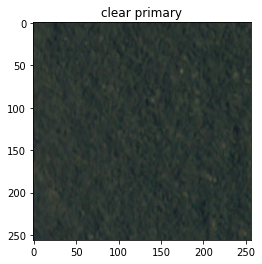

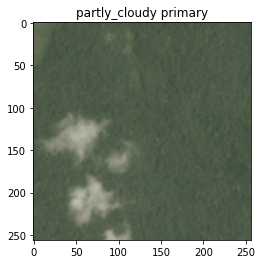

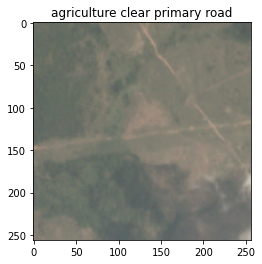

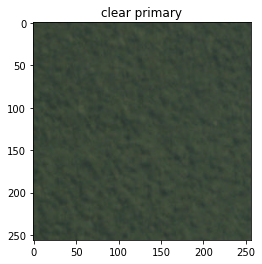

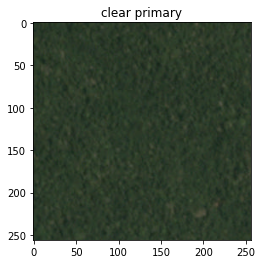

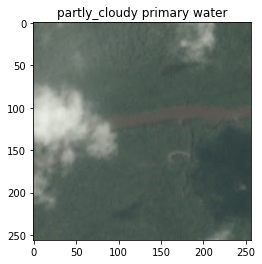

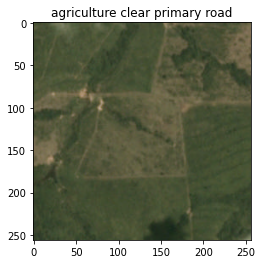

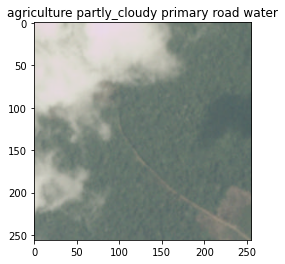

In [ ]:
import random
root = "/content/train-jpg"
train_path = [os.path.join(root,x + ".jpg") for x in df["image_name"]]
labels = df["tags"]
pairs = list(zip(train_path, labels))  # make pairs out of the two lists
pairs = random.sample(pairs, 10)  # pick 3 random pairs
image_paths, labels = zip(*pairs)
for image_path,label_name in zip(image_paths,labels):
  read_image = plt.imread(image_path)
  plt.title(label_name)
  plt.imshow(read_image)
  plt.show()

**Load Training images**

In [ ]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

#using the lambda function to create our labels
labels = list(set(flatten([l.split(' ') for l in df['tags'].values])))

#Creating our label map
label_map = {l: i for i, l in enumerate(labels)}

In [ ]:
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'blow_down', 'blooming', 'selective_logging', 'habitation', 'clear', 'partly_cloudy', 'bare_ground', 'road', 'artisinal_mine', 'conventional_mine', 'agriculture', 'primary', 'cultivation', 'haze', 'slash_burn', 'water', 'cloudy'}


In [ ]:
# converting the tags columns into one_hot_vectors
for tag in labels_set:
    df[tag] = df['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
df['image_name'] = df['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
df.head()

,image_name,tags,blow_down,blooming,selective_logging,habitation,clear,partly_cloudy,bare_ground,road,artisinal_mine,conventional_mine,agriculture,primary,cultivation,haze,slash_burn,water,cloudy
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0


In [ ]:
from keras import backend as K
# calculate the fbeta_score
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

In [ ]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam
import keras_preprocessing

**Loading training and validation data with training**

In [ ]:
train_path = "/content/train-jpg"
y_col = list(df.columns[2:]) 
train_image_gen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

    

# creating the training set
training_set = train_image_gen.flow_from_dataframe(dataframe=df, directory=train_path, x_col='image_name', y_col=y_col, \
       target_size=(224,224), class_mode='raw', seed=2, batch_size=128, subset='training')

# creating the validation set
validation_set = train_image_gen.flow_from_dataframe(dataframe=df, directory=train_path, x_col='image_name', y_col=y_col, \
       target_size=(224,224), class_mode='raw', seed=2, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


**Traning with LeNet**

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224,224, 3)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(17, activation='sigmoid'))





In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [ ]:
#Compile model
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy', fbeta_score_K])

In [ ]:
history = History()
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=0)]
# setting step size for training and validation image data
step_train_size = int(np.ceil(training_set.samples / training_set.batch_size))
step_val_size = int(np.ceil(validation_set.samples / validation_set.batch_size))
history = model.fit(x=training_set, steps_per_epoch=step_train_size, validation_data=validation_set, validation_steps=step_val_size,
         epochs=20, callbacks=callbacks)


Epoch 1/20
  9/253 [>.............................] - ETA: 1:13:53 - loss: 0.5520 - accuracy: 0.0417 - fbeta_score_K: 0.4877

KeyboardInterrupt: ignored

In [ ]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID,shuffle = True)


def evaluate_model(model, generator, nBatches):
    score = model.evaluate_generator(generator=generator,               # Generator yielding tuples
                                     steps=generator.samples//nBatches, # number of steps (batches of samples) to yield from generator before stopping
                                     max_queue_size=10,                 # maximum size for the generator queue
                                     workers=0,                         # maximum number of processes to spin up when using process based threading
                                     use_multiprocessing=False,         # whether to use process-based threading
                                     verbose=0,shuffle = False)
    print("loss: %.3f - acc: %.3f" % (score[0], score[1]))

In [ ]:
scores = model.evaluate_generator(test_generator,1514) #1514 testing images
print("Accuracy = ", scores[1])


# Evaluate on Validation data
scores = model.evaluate(val_data_gen)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

scores = model.evaluate_generator(val_data_gen)
print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))



scoreSeg = model.evaluate_generator(validation_generator, 400)
print("Accuracy = ",scoreSeg[1])

evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
    batch_size=batch_size, shuffle=False),
    steps=x_test.shape[0] // batch_size, workers=4)

In [ ]:
score = model.evaluate_generator(validation_generator, nb_validation_samples/batch_size, workers=12)

scores = model.predict_generator(validation_generator, nb_validation_samples/batch_size, workers=12)

correct = 0
for i, n in enumerate(validation_generator.filenames):
    if n.startswith("cats") and scores[i][0] <= 0.5:
        correct += 1
    if n.startswith("dogs") and scores[i][0] > 0.5:
        correct += 1

print("Correct:", correct, " Total: ", len(validation_generator.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])


metrics = model.evaluate_generator(val_batches,10,10,workers=1,pickle_safe=False)
print("model accuracy:",metrics[1])

score = model.evaluate_generator(
                       gen_for_test.generator,
                       length_of_test_data,
                       max_q_size=data_on_ram
                       )

print "The score is:", score[0]
print "The accuracy is:", score[1]

**Predicting on test data**

In [ ]:
# Read  sample submission csv
sample_submission = pd.read_csv("/content/drive/MyDrive/Hamoye Internship/StageD/Data/sample_submission_v2.csv")

In [ ]:
#Add jpg as extension
sample_submission["image_name"] = sample_submission["image_name"].apply(lambda x : x +".jpg")
sample_submission.head()


,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [ ]:
#Divide sample submission into test and additional test dataframes
first_test = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
first_test.tail()

,image_name
40664,test_40664.jpg
40665,test_40665.jpg
40666,test_40666.jpg
40667,test_40667.jpg
40668,test_40668.jpg


In [ ]:
#Additional test images
second_test = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
second_test.tail()

,image_name
20517,file_9995.jpg
20518,file_9996.jpg
20519,file_9997.jpg
20520,file_9998.jpg
20521,file_9999.jpg


**Predict on first set of test images**

In [ ]:
test_image_gen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_path = "/content/test-jpg"
test_gen = test_image_gen.flow_from_dataframe(dataframe=first_test, \
            directory=test_path, x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(224,224))


step_test_size1 = int(np.ceil(test_gen.samples / test_gen.batch_size)) 
test_gen.reset() # reseting the generator to be sure of avoiding shuffling
pred = model.predict(test_gen, steps=step_test_size1, verbose=1)

In [ ]:
unique_labels = ['blooming', 'artisinal_mine', 'clear', 'selective_logging', 'haze', 'primary', 'road', 'bare_ground', 'slash_burn', 'water', 'agriculture', 'cultivation', 'blow_down', 'habitation', 'partly_cloudy', 'cloudy', 'conventional_mine']
len(unique_labels)

17

In [ ]:
test_file_names1 = test_gen.filenames # storing the filenames (images names) of the first set of images      
# converting the predictions of the first 40669 to tag names
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
import pandas as pd
first_result = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags})
print(first_result.head())